# Clustering Hidden Markov Models with Variational Hierarchical Expectation-Maximization (VHEM)
Benton Liang, Madeleine Nakada, Hurlink Vongsachang, Michael Yue

*Based on the 2014 paper by Coviello et. al.*

In [0]:
# Install scikit-learn's implementation of HMMs (with Baum-Welch and Viterbi), hmmlearn
!pip install hmmlearn

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import *
import hmmlearn.hmm as hmml

# Introduction

Given a hidden Markov mixture model $\mathcal{M}^{(b)}$ composed of $K^{(b)}$ component HMMs, the goal of this paper is to implement an algorithm, variational hierarchical expectation-maximization, to find the reduced model $\mathcal{M}^{(r)}$ with $K^{(r)}$ components where $K^{(r)}<K^{(b)}$.

The claim made in the paper is that HMMs cannot be clustered via their parameters (i.e., transition matrices, emission probabilities alone), since multiple sets of parameters can map to the same underlying distribution, making clustering over parameter space useless. A more meaningful clustering is based on the underlying distribution of the HMMs themselves: namely, we maximize the expected log-likelihood over al (specifically, a variational lower bound using a family of Gaussian mixture models). As a naive check on this claim, the relative success of this algorithm in comparison to traditional K-means clustering of parameters is what we will test below.

It should also be noted that this specific model is not the only model that clusters via the underlying distributions of HMMs (i.e. Jebara et al., 2007), and shows improved performance compared to these other algorithms for more cosmetic reasons (Coviello et al.'s algorithm can learn *new* HMMs whose distributions represent the centers of HMMs clusters, and no sampling steps are required).

The paper derives a hierarchical expectation maximization (HEM) algorithm that, starting from a weighted group of HMMs termed a Hidden Markov Mixture Model (H3M) representing some overall model, estimates an H3M with fewer component HMMs that concisely represents and clusters the input HMMs (i.e., the input HMM distributions guide the estimation of the output mixture distribution). Each HMM has a Gaussian mixture model (GMM) modeling emission from a given hidden state; that is, the number of hidden states an HMM has is also the number of GMMs corresponding to it. This hierarchical model allows for maximum flexibility when learning the HMMs to model some arbitrary H3M distribution.

# Problem Statement

Hidden Markov Models (HMMs), which are probabilistic models that aim to model sequential outputs over a series of hidden states, are an important class of models used for speech recognition, music analysis, identification, and time-series data. This paper by Coviello et al. aims to demonstrate an algorithm that can successfully cluster HMMs better than existing approaches that cluster HMMs.

# Context & Scope

After generating a bunch of HMMs, sometimes it might be useful to cluster these HMMs, in which case “clustering” refers to generating a new HMM that is representative of a group of “similar” HMMs. Applications of such HMM-clustering algorithms can be useful for clustering time-series data such as motion capture and music, hierarchical indexing for fast retrieval, and reducing the computational complexity of estimating mixtures of HMMs from large data sets (Coviello et al.). However, clustering of HMMs is not fairly well-researched field, and thus this paper aims to expand on the limited research that exists today.

# Existing Work

Much of the existing work prior to Coviello et al. has focused on clustering HMMs based on their parameter space using naive methods such as k-means. However, as the authors point out, these naive methods fail when the HMM cannot be represented as a real vector in the euclidean space since then the difference between two HMMs cannot be calculated. Although there are some solutions to clustering HMMs that can’t be represented in euclidean space including spectral clustering, the authors assert that with these existing methods there is no way to generate the cluster center of a cluster. Rather, the only way to represent a cluster is to select one of the models in the cluster closest to the center, but there is no guarantee that this is truly the center of the cluster. This becomes especially problematic when the clusters contain only a few models since they may be spread out and no one model may be representative of the cluster. The KL-divergence can be a method of measuring distance between models in this type of cluster, but it relies on sampling which in a high dimensional sample space can be unreliable. 

# Contributions
This paper offers a novel solution to the above shortcomings of existing HMM VHEM algorithms by clustering HMMs with respect to their probability distributions rather than parameters of the HMM or real samples. The algorithm utilizes virtual sampling by weighting the parameters of the different HMMs rather than actually sampling from H3M model.


# Notation

Below is the notation used in the paper (copied from Table 1). The notation is important because it allows us to differentiate between the base model and the reduced model.

#### Variables
| *variables* | *base model (b)* | *reduced model (r)* |
|--------------------|--------------------|--------------------|
| index for HMM components | $i$ | $j$ |
| number of HMM components | $K^{(b)}$ | $K^{(r)}$ |
| HMM states | $\beta$ | $\rho$ |
| HMM state sequence | $\mathbf{\beta}=\{\beta_1,\dots,\beta_\tau\}$ |  $\mathbf{\rho}=\{\rho_1,\dots,\rho_\tau\}$ |
| index for component of GMM | $m$ | $\ell$ |
| number of Gaussian components | $M$ | $M$|

#### Models
| *variables* | *base model (b)* | *reduced model (r)* |
|--------------------|--------------------|--------------------|
| H3M | $\mathcal{M}^{(b)}$ | $\mathcal{M}^{(r)}$ |
| HMM component | $\mathcal{M}^{(b)}_i$ | $\mathcal{M}^{(r)}_j$
| GMM emission | $\mathcal{M}^{(b)}_{i,\beta}$ | $\mathcal{M}^{(b)}_{j,\rho}$ |
| Gaussian component | $\mathcal{M}^{(b)}_{i,\beta,m}$ | $\mathcal{M}^{(b)}_{j,\rho,\ell}$ |

#### Parameters
| *variables* | *base model (b)* | *reduced model (r)* |
|--------------------|--------------------|--------------------|
| H3M component weight | $\omega_i^{(b)}$ | $\omega_j^{(r)}$ |
| HMM initial state | $\pi^{(b),i}$ |  $\pi^{(r),j}$ | 
| HMM state transition matrix | $A^{(b),i} $ | $A^{(r),ij} $ |
| GMM emission | $\{c_{\beta,m}^{(b),i},\mu_{\beta,m}^{(b),i},\Sigma_{\beta,m}^{(b),i}\}_{m=1}^M$ | $\{c_{\rho,\ell}^{(r),j},\mu_{\rho,\ell}^{(r),j},\Sigma_{\rho,\ell}^{(r),j}\}_{\ell=1}^M$ |


We've visualized the relation between the models below

![alt text](https://drive.google.com/uc?export=view&id=10WYqPzrHqZQSGtjTzzTvlfFbCM9-NgLB)


In [0]:
# Gaussian Mixture Model
class GMM():
  def __init__(self, emissions):
    # emissions is [[c, mu, Sigma] * (number of Gaussian components = M)], with c's adding to 1
    self.emissions = np.array(emissions)
    self.M = len(emissions)
    self.components, self.means, self.sigma = np.array(emissions)[:, 0], np.array(emissions)[:, 1], np.array(emissions)[:, 2]

# HMM has len(pi) = len(A[0]) = len(gmm) possible hidden states, each with its own possible GMM emissions
class HMM():
  def __init__(self, pi, A, gmms):
    self.pi = pi
    self.transitions = A
    self.gmms = gmms

# H3M is made up of HMMs
class H3M():
  def __init__(self, omega, hmms):
    self.components = omega
    self.hmms = hmms

# Technical Details / Algorithm

We follow the format of a fairly typical EM algorithm. Most of the complexity comes from the fact that we have a hierarchical model composed of more simple models (H3Ms being a mixture of HMMs, and HMMs having a Gaussian mixture model for emission from each hidden state). Starting with the innermost model, a Gaussian mixture model, we compute the expected log-likelihood and variational lower bound and use that lower bound to calculate a variational lower bound for the model one level in the hierarchy up. Working backwards to the most complex model, we then maximize the lower bound over parameters for our proposed reduced model and get new parameters for HMMs in the reduced model.

We alternate the expectation and maximization steps until the difference in our overall objective function, the expected log-likelihood of our virtual samples, reaches a stopping threshold of $10^{-3}$.

**Expectation Step**

*Goal: obtain a family of lower bounds to the expected log-likelihood and then optimize over variational parameters to find the lower bound to the expected log likelihood.*
1. For each pair of HMMS $\mathcal{M}_i^{(s)}$ and $\mathcal{M}_j^{(r)}$
  1. For each pair of emission GMMS for state $\beta$ of $\mathcal{M}_i^{(s)}$ and $\rho$ of $\mathcal{M}_j^{(r)}$ 
    1. Compute the optimal variational distribution for the GMMs, where $\hat{\eta}_{\ell|m}^{(i,\beta),(j,\rho)}$ is intuitively the probability that component $m$ for state $\rho$ from the $j$th HMM in the reduced model corresponds to the component $\ell$ for state $\beta$ in the $i$th HMM in the base model
    $$\hat{\eta}_{\ell|m}^{(i,\beta),(j,\rho)}=\frac{c^{(r),j}_{\rho,\ell}\exp\{E_{\mathcal{M}_{i,\beta,m}^{(b)}}[\log p(y|\mathcal{M}_{j,\rho,\ell}^{(r)})]}{\sum_{\ell'}c^{(r),j}_{\rho,\ell'}\exp\{E_{\mathcal{M}_{i,\beta,m}^{(b)}}[\log p(y|\mathcal{M}_{j,\rho,\ell'}^{(r)})]\}}$$
    4. Use the optimal variational distribution to calculate the optimal lower bound to the expected log likelihood 
    $$\mathcal{L}_{GMM}^{(i,\beta),(j,\rho)}=\sum_{m=1}^Mc_{\beta,m}^{(b),i}\sum_{\ell=1}^M\hat{\eta}_{\ell|m}^{(i,\beta),(j,\rho)}\Bigg\{\log\frac{c^{(r),j}_{\rho,\ell}}{\hat{\eta}_{\ell|m}^{(i,\beta),(j,\rho)}}+E_{\mathcal{M}_{i,\beta,m}^{(b)}}[\log p(y|\mathcal{M}_{j,\rho,\ell}^{(r)}]\Bigg\}$$
           Where (in our case having $d=1$ due to one-dimensional data in the HMMs)
      $$E_{\mathcal{M}_{i,\beta,m}^{(b)}}[\log p(y|\mathcal{M}_{j,\rho,\ell}^{(r)}]=-\frac{d}{2}\log 2\pi - \frac{1}{2}\log|\Sigma_{\rho,\ell}^{(r),j}|-\frac{1}{2}\text{tr}\big(\Sigma_{\rho,\ell}^{(r),j})^{-1}\Sigma_{\beta,m}^{(b),i}\big)-\frac{1}{2}\Big(\mu_{\rho,\ell}^{(r),j}-\mu_{\beta,m}^{(b),i}\Big)^T\Big(\Sigma_{\rho,\ell}^{(r),j}\Big)^{-1}\Big(\mu_{\rho,\ell}^{(r),j}-\mu_{\beta,m}^{(b),i}\Big)$$
  5. Recursively compute the optimal variational distributions for the HMMs using the lower bounds from the GMMs
        * For $t=\tau,\dots,2$ compute with 
        $$\hat{\phi}_t^{i,j}(\rho_1|\beta_1)=\frac{a_{\rho_{t-1},\rho_t}^{(r),j}\exp\big\{\mathcal{L}_{GMM}^{(i,\beta_t),(j,\rho_t)}+\mathcal{L}_{t+1}^{i,j}(\beta_t,\rho_t)\big\}}{\sum_\rho^Sa_{\rho_{t-1},\rho_t}^{(r),j}\exp\big\{\mathcal{L}_{GMM}^{(i,\beta_t),(j,\rho_t)}+\mathcal{L}_{t+1}^{i,j}(\beta_t,\rho)\big\}}$$
          Where 
          $$\mathcal{L}_t^{i,j}(\beta_{t-1},\rho_{t-1})=\sum_{\beta=1}^Sa_{\beta_{t-1},\beta}^{(b),i}\log\sum_{\rho=1}^Sa_{\rho_{t-1},\rho}^{(r),j}\exp\big\{\mathcal{L}_{GMM}^{(i,\beta_1),(j,\rho_1)}+\mathcal{L}_2^{(i,j)}(\beta,\rho)\big\}$$
          And base case
          $$\mathcal{L}_{\tau+1}^{i,j}(\beta_t,\rho_t)=0$$
        * Compute the initial case
        $$\hat{\phi}_1^{i,j}(\rho_1|\beta_1)=\frac{\pi_{\rho_1}^{(r)}\exp\big\{\mathcal{L}_{GMM}^{(i,\beta_1),(j,\rho_1)}+\mathcal{L}_2^{i,j}(\beta_1,\rho_1)\big\}}{\sum_\rho^S\pi_\rho^{(r),j}\exp\big\{\mathcal{L}_{GMM}^{(i,\beta_1),(j,\rho_1})+\mathcal{L}_2^{i,j}(\beta_1,\rho)\big\}}$$
  6. Compute the optimal lower bound for the expected log-likelihood for the HMMs
  $$
\mathcal{L}_{H M M}^{i, j}=\sum_{\boldsymbol{\beta}} \pi_{\boldsymbol{\beta}}^{(b), i} \sum_{\boldsymbol{\rho}} \hat{\phi}^{i, j}(\boldsymbol{\rho} | \boldsymbol{\beta})\left\{\log \frac{\pi_{\boldsymbol{\rho}}^{(r), j}}{\hat{\phi}^{i, j}(\boldsymbol{\rho} | \boldsymbol{\beta})}+\sum_{t} \mathcal{L}_{G M M}^{\left(i, \beta_{t}\right),\left(j, \rho_{t}\right)}\right\}
$$
7. Compute the optimal assignment probabilities of the $i$th HMM in the base model to the $j$th HMM in the reduced
$$\hat{z}_{ij}=\frac{\omega_j^{(r)}\exp(N\omega_i^{(b)}\mathcal{L}_{HMM}^{i,j})}{\sum_{j'}\omega_{j'}^{(r)}\exp(N\omega_i^{(b)}\mathcal{L}_{HMM}^{(i,j')})}$$
8. For each pair of HMMs $\mathcal{M}_i^{(s)}$ and $\mathcal{M}_j^{(r)}$ compute the following summary statistics
  1. Expected number of times the HMM $\mathcal{M}_j^{(r)}$ starts from state $\rho$ when modeling sequences generated by $\mathcal{M}_i^{(b)}$
  $$\hat{v}_1^{i,j}(\rho)=\sum_{\beta=1}^Sv_1^{i,j}(\rho,\beta)$$
  Where $$v_1^{i,j}(\rho_1,\beta_1)=\pi_{\beta_1}^{(b),i}\rho_1^{i,j}(\rho_1|\beta_1)$$
  2. The expected number of times that the HMM $\mathcal{M}_j^{(r)}$ is in state $\rho$ when $\mathcal{M}_i^{(b)}$ is in state $\beta$ when both HMMs are modeling sequences generated by $\mathcal{M}_i^{(b)}$
  $$\hat{v}^{i,j}(\rho,\beta)=\sum_{t=1}^\tau v_t^{i,j}(\rho,\beta)$$
  Where
  $$v^{i,j}_t(\rho_t,\beta_t)=\sum_{\rho_{t-1}=1}^S\xi_t^{i,j}(\rho_{t-1},\rho_t,\beta_t)$$
  And
  $$\xi_t^{i,j}(\rho_{t-1},\rho_t,\beta_t)=\Big(\sum_{\beta_{t-1}=1}^Sv_{t-1}^{i,j}(\rho_{t-1},\beta_{t-1})a_{\beta_{t-1},\beta_t}^{(b),i}\Big)\hat{\phi}_t^{i,j}(\rho_t|\rho_{t-1},\beta_t)$$
  For $t=2,\dots,\tau$
  3. The expected number of transitions from state $\rho$ to $\rho'$ in $\mathcal{M}_j^{(r)}$ when modeling sequences from $\mathcal{M}_i^{(b)}$
  $$\hat{\xi}^{i,j}(\rho,\rho')=\sum_{t=1}^\tau\sum_{\beta=1}^S\xi_t^{i,j}(\rho,\rho',\beta)$$
    Using the equation from above


**Maximization Step**
*Goal: Given the lower bounds from the E-Step, maximize the lower bound with respect to parameters of $\mathcal{M}^{(r)}$. This is done by plugging the above values into the following equations to solve for updated parameters of $\mathcal{M}^{(r)}$:*
$$
\omega_j^{(r)*} = \frac{\sum_{i=1}^{K^{(b)}} \hat{z}_{i,j}}{K^{(b)}}
$$

$$
\pi_{\rho}^{(r), j^{*}}=\frac{\sum_{i=1}^{K^{(b)}} \hat{z}_{i, j} \omega_{i}^{(b)} \hat{\nu}_{1}^{i, j}(\rho)}{\sum_{\rho^{\prime}=1}^{S} \sum_{i=1}^{K^{(b)}} \hat{z}_{i, j} \omega_{i}^{(b)} \hat{\nu}_{1}^{i, j}\left(\rho^{\prime}\right)}
\quad\quad
a_{\rho, \rho^{\prime}}^{(r), j^{*}}=\frac{\sum_{i=1}^{K^{(b)}} \hat{z}_{i, j} \omega_{i}^{(b)} \hat{\xi}^{i, j}\left(\rho, \rho^{\prime}\right)}{\sum_{\sigma=1}^{S} \sum_{i=1}^{K^{(b)}} \hat{z}_{i, j} \omega_{i}^{(b)} \hat{\xi}^{i, j}(\rho, \sigma)}
$$

$$
c_{\rho, \ell}^{(r), j^{*}}=\frac{\Omega_{j, \rho}\left(\hat{\eta}_{\ell | m}^{(i, \beta),(j, \rho)}\right)}{\sum_{\ell^{\prime}=1}^{M} \Omega_{j, \rho}\left(\hat{\eta}_{\ell^{\prime} | m}^{(i, \beta),(j, \rho)}\right)}
\quad\quad
\mu_{\rho, \ell}^{(r), j^{*}}=\frac{\Omega_{j, \rho}\left(\eta_{\ell | m}^{(i, \beta),(j, \rho)} \mu_{\beta, m}^{(b), i}\right)}{\Omega_{j, \rho}\left(\hat{\eta}_{\ell | m}^{(i, \beta),(j, \rho)}\right)}
$$

$$
\Sigma_{\rho, \ell}^{(r), j^{*}}=\frac{\Omega_{j, \rho}\left(\hat{\eta}_{\ell | m}^{(i, \beta),(j, \rho)}\left[\Sigma_{\beta, m}^{(b), i}+\left(\mu_{\beta, m}^{(b), i}-\mu_{\rho, \ell}^{(r), j}\right)\left(\mu_{\beta, m}^{(b), i}-\mu_{\rho, \ell}^{(r), j}\right)^{T}\right]\right)}{\Omega_{j, \rho}\left(\hat{\eta}_{\ell | m}^{(i, \beta),(j, \rho)}\right)}
$$

Where $\Omega$ is the weighted sum over all base GMM components across all HMMs


$$
\Omega_{j, \rho}(f(i, \beta, m))=\sum_{i=1}^{K^{(b)}} \hat{z}_{i, j} \omega_{i}^{(b)} \sum_{\beta=1}^{S} \hat{\nu}^{i, j}(\rho, \beta) \sum_{m=1}^{M} c_{\beta, m}^{(b), i} f(i, \beta, m)
$$

We repeat the expectation and maximum steps until convergence, as judged by changes in $\mathcal{L}_{H3M}$.

# Implementation

In [0]:
class VHEM():
  def __init__(self, base: H3M, reduced: H3M, N: int, tau: int, states):
    # base and reduced H3M models
    self.base = base
    self.reduced = reduced

    # number of virtual samples
    self.N = N

    # time that we sample over
    self.tau = tau

    # all possible states [0, ..., S]
    self.states = states
    self.S = len(states)

    # number of base and reduced components
    self.K_base = len(base.components)
    self.K_reduced = len(reduced.components)

  def init_ixj(self, val=None):
    return [[val for _ in range(self.K_reduced)] for _ in range(self.K_base)]

  # initializes an SxS matrix
  def init_betaxrho(self):
    return [[None for _ in self.states] for _ in self.states]

  # -------- LINE 8 --------
  # takes in vectors of c, mu, sigma and returns vector
  # assumes one dimension
  def expected_log_likelihood(self, base_em, red_em):
    _, b_mean, b_sigma = base_em
    _, r_mean, r_sigma = red_em
    return -1/2*np.log(2*np.pi) -1/2*np.log(r_sigma) - 1/2*b_sigma/r_sigma - 1/2/r_sigma*(r_mean - b_mean)**2
    
  # passing in [components, means, sigmas]
  def optimal_var_dist(self, base_gau, red_gau):
    r_c, _, _ = red_gau
    numerator = r_c * np.exp(self.expected_log_likelihood(base_gau, red_gau))
    denominator = np.sum(numerator)
    return numerator / denominator

  # -------- LINE 9 --------
  def lower_bound(self, base_em, red_em, etas):
    b_c = np.array(base_em)[:, 0]
    r_c = np.array(red_em)[:, 0]
    lb = 0
    for m in range(len(base_em)):
      s = 0
      for l in range(len(red_em)):
        s += etas[m][l] * (np.log(r_c[l]/etas[m][l]) + self.expected_log_likelihood(base_em[m], red_em[l]))
      lb += b_c[m] * s
    return lb

  # -------- LINE 10 --------
  def phi_hat(self, l, a, A, lgmm, last_rho):
    return a * np.exp(lgmm + l) / np.sum([A[last_rho][rho] * np.exp(lgmm + l) for rho in self.states])

  def new_l(self, A_base, A_reduced, beta_last, rho_last, LGMM, L):
    return np.sum([A_base[beta_last][beta] * np.log(np.sum([A_reduced[rho_last][rho] * np.exp(LGMM[beta][rho] + L[beta][rho]) for rho in self.states])) for beta in self.states])

  # -------- LINE 11 --------
  def get_sequences(self):
    sequences = np.array(self.states).reshape(len(self.states), 1).tolist()
    for _ in range(self.tau-1):
      s = []
      for sequence in sequences:
        for state in self.states:
          s.append(sequence + [state])
      sequences = s
    return sequences

  def iterate_optimal_dists(self, tau, A_base, A_reduced, LGMM, L, base_pi, reduced_pi):
    L_new = self.init_betaxrho()
    if tau > 1:
      phis = self.init_betaxrho()
      for beta in self.states:
        for rho in self.states:
          rho_list = []
          for rho_last in self.states:
            rho_list.append(self.phi_hat(L[beta][rho], A_reduced[rho_last][rho], A_reduced, LGMM[beta][rho], rho_last))
          phis[beta][rho] = rho_list
          L_new[beta][rho] = self.new_l(A_base, A_reduced, beta, rho, LGMM, L)  
      phi_list, final_L = self.iterate_optimal_dists(tau-1, A_base, A_reduced, LGMM, L_new, base_pi, reduced_pi) 
      phi_list += [phis]
      return phi_list, final_L
    else:
      phis = self.init_betaxrho()
      for beta in self.states:
        for rho in self.states:
          phis[beta][rho] = reduced_pi[rho] * np.exp(LGMM[beta][rho] + L[beta][rho]) / np.sum([reduced_pi[rho] * np.exp(LGMM[beta][rho] + L[beta][rho]) for rho in self.states])
      final_L = np.sum([base_pi[beta] * np.log(np.sum([reduced_pi[rho] * np.exp(LGMM[beta][rho] + L[beta][rho]) for rho in self.states])) for beta in self.states])
      return [phis], final_L

  def sum_lgmm(self, betas, rhos, LGMM):
    return np.sum([LGMM[beta][rho] for beta, rho in list(zip(betas, rhos))])

  def calculate_phi(self, phis, rhos, betas, tau):
    accumulator = 1
    for t in range(tau):
      phi = phis[t]
      rho = rhos[t]
      beta = betas[t]
      if t > 0:
        last_rho = rhos[t-1]
        accumulator = accumulator * phi[beta][rho][last_rho]
      else:
        accumulator = accumulator * phi[beta][rho]
        
    return accumulator

  def Omega(self, etas, K, M, c, j, rho, l, v, z, weights, params, f):
    i_acc = 0
    for i in range(K):
      beta_acc = 0
      for beta in self.states:
        m_acc = 0
        for m in range(M):
          m_acc += c[i][beta][m] * f(etas, i, j, beta, rho, m, l, params) 
        beta_acc += m_acc * v[i][j][beta][rho]
      i_acc += beta_acc * z[i][j] * weights[i]
    return i_acc

  def run_VHEM(self):
    
    # LINE 3 repeat until convergence
    last_val = 0
    diff = -1
    objective_list = []
    
    while diff > 10e-3 or diff < 0:
      print("diff: ",diff)

      # LINE 6 for each pair of HMMS
      phis = self.init_ixj()
      LHMMs = self.init_ixj()
      etas = self.init_ixj(self.init_betaxrho())
  
      for i, base_hmm in enumerate(self.base.hmms):
        for j, red_hmm in enumerate(self.reduced.hmms):
          # S x S to store lower bounds
          LGMM = self.init_betaxrho()
          
          # LINE 7 for each pair of emission GMMS for state beta of base and state rho of reduced
          for beta, base_gmm in enumerate(base_hmm.gmms):
            for rho, red_gmm in enumerate(red_hmm.gmms):
              base_emission = base_gmm.emissions
              red_emission = red_gmm.emissions
              # M x M to store eta
              eta = [[None for _ in range(len(red_emission))] for _ in range(len(base_emission))]
              # iterates over gaussian components
              for l, base_gaussian in enumerate(base_emission):
                for m, red_gaussian in enumerate(red_emission):
                  # assuming gmm is list of [(c, mu, sigma)]
                  eta[l][m] = self.optimal_var_dist(base_gaussian, red_gaussian)
                LGMM[beta][rho] = self.lower_bound(base_emission, red_emission, eta)
              etas[i][j][beta][rho] = eta

          phis[i][j], LHMMs[i][j] = self.iterate_optimal_dists(self.tau, base_hmm.transitions, red_hmm.transitions, LGMM, np.zeros_like(LGMM), base_hmm.pi, red_hmm.pi)
          sequences = self.get_sequences()
      # compute optimal assignment probabiliities
      zs = []
      for i in range(self.K_base):
        z = []
        for j in range(self.K_reduced):
          z_ij = self.reduced.components[j] * np.exp(self.N * self.base.components[i] * LHMMs[i][j]) / np.sum([self.reduced.components[j_prime] * np.exp(self.N * self.base.components[i] * LHMMs[i][j_prime]) for j_prime in range(self.K_reduced)])
          z.append(z_ij)
        zs.append(z)
      # compute aggregate summary statistics
      v1s = self.init_ixj()
      for i in range(self.K_base):
        for j in range(self.K_reduced):
          v1s[i][j] = [[self.base.hmms[i].pi[beta] * phis[i][j][0][beta][rho] for beta in self.states] for rho in self.states]

      v_intermediate = [v1s]
      xi_intermediate = [None]
      for t in range(1, self.tau):
        last_v = v_intermediate[-1]
        temp_xis = [[[[[np.sum([last_v[i][j][last_beta][last_rho] * self.base.hmms[i].transitions[last_beta][beta] for last_beta in self.states]) * phis[i][j][t][beta][rho][last_rho] for last_rho in self.states] for rho in self.states] for beta in self.states] for j in range(self.K_reduced)] for i in range(self.K_base)]
        temp_vs = [[[[np.sum([temp_xis[i][j][beta][rho][last_rho] for last_rho in self.states]) for rho in self.states] for beta in self.states] for j in range(self.K_reduced)] for i in range(self.K_base)]
        xi_intermediate.append(temp_xis)
        v_intermediate.append(temp_vs)

      v1_aggregate = self.init_ixj()
      for i in range(self.K_base):
        for j in range(self.K_reduced):
          v1_aggregate[i][j] = [np.sum([v1s[i][j][beta][rho] for rho in self.states]) for beta in self.states]

      v_aggregate = self.init_ixj()
      for i in range(self.K_base):
        for j in range(self.K_reduced):
          v_aggregate[i][j] = [[np.sum([v_intermediate[t][i][j][beta][rho] for t in range(self.tau)]) for rho in self.states] for beta in self.states]

      xi_aggregate = self.init_ixj()
      for i in range(self.K_base):
        for j in range(self.K_reduced):
          xi_aggregate[i][j] = [[np.sum([np.sum([xi_intermediate[t][i][j][beta][rho_prime][rho] for beta in self.states]) for t in range(1, self.tau)]) for rho_prime in self.states] for rho in self.states]

      # for each component in reduced recompute parameters
      for j, hmm in enumerate(self.reduced.hmms):
        self.reduced.components[j] = np.sum([zs[i][j] for k in range(self.K_reduced)]) / self.K_reduced

        pi_denom = np.sum([np.sum([zs[i][j] * self.base.components[i] * v1_aggregate[i][j][rho_prime] for i in range(self.K_base)]) for rho_prime in self.states])
        hmm.pi = [np.sum([zs[i][j] * self.base.components[i] * v1_aggregate[i][j][rho] for i in range(self.K_base)]) for rho in self.states] / pi_denom

        hmm.transitions = [[np.sum([zs[i][j] * self.base.components[i] * xi_aggregate[i][j][rho][rho_prime] for i in range(self.K_base)]) / np.sum([np.sum([zs[i][j] * self.base.components[i] * xi_aggregate[i][j][rho][sigma] for i in range(self.K_base)]) for sigma in self.states]) for rho_prime in self.states] for rho in self.states]

        all_gmm_components = [[gmm.components for gmm in hmm.gmms] for hmm in self.base.hmms]
        all_gmm_means = [[gmm.means for gmm in hmm.gmms] for hmm in self.base.hmms]
        all_gmm_sigma = [[gmm.sigma for gmm in hmm.gmms] for hmm in self.base.hmms]
        old_reduced_means = [[gmm.means for gmm in hmm.gmms] for hmm in self.reduced.hmms]

        # one emission GMM for each state
        for rho, gmm in enumerate(hmm.gmms):
          c_func = lambda etas, i, j, beta, rho, m, l, params: etas[i][j][beta][rho][l][m]
          M=len(gmm.components)
          gmm.components = [self.Omega(etas=etas, K=self.K_base, M=M, c=all_gmm_components, j=j, rho=rho, l=ell, v=v_aggregate, z=zs, weights=self.base.components, params=None, f=c_func) / np.sum([self.Omega(etas, self.K_base, len(gmm.components), all_gmm_components, j, rho, ell_prime, v_aggregate, zs, self.base.components, None, c_func) for ell_prime in range(len(gmm.components))]) for ell in range(M)]
          mean_func = lambda etas, i, j, beta, rho, m, l, params: etas[i][j][beta][rho][l][m] * params["mu"][i][beta][m]
          mean_params = {"mu" : all_gmm_means}
          gmm.means = [self.Omega(etas, self.K_base, len(gmm.components), all_gmm_components, j, rho, ell, v_aggregate, zs, self.base.components, mean_params, mean_func) / self.Omega(etas, self.K_base, len(gmm.components), all_gmm_components, j, rho, ell, v_aggregate, zs, self.base.components, None, c_func) for ell in range(M)]
          sigma_func = lambda etas, i, j, beta, rho, m, l, params:  etas[i][j][beta][rho][l][m] * (params["sigma"][i][beta][m] + (params["base_mus"][i][beta][m] - params["red_mu"][j][rho][l]) * (params["base_mus"][i][beta][m] - params["red_mu"][j][rho][l]).T)
          sigma_params = {"base_mus" : all_gmm_means, "red_mu" : old_reduced_means, "sigma" : all_gmm_sigma}
          gmm.sigma = [self.Omega(etas = etas, K = self.K_base, M = M, c=all_gmm_components, j=j, rho=rho, l=ell, v=v_aggregate, z=zs, weights=self.base.components, params=sigma_params, f=sigma_func) / self.Omega(etas=etas, K=self.K_base, M=M, c=all_gmm_components, j=j, rho=rho, l=ell, v=v_aggregate, z=zs, weights=self.base.components, params=None, f=c_func) for ell in range(M)]
      objective_func = np.max([np.sum([zs[i][j] * (np.log(self.reduced.components[j] / zs[i][j]) + self.N * self.base.components[j] * LHMMs[i][j]) if zs[i][j] != 0 else 0 for j in range(self.K_reduced)]) for i in range(self.K_base)])
      print("OBJ", objective_func)
      diff = 0
      if diff == -1:
        diff = -2
      else:
        diff = abs(last_val - objective_func)
      print("new diff", diff)
      last_val = objective_func
      objective_list.append(objective_func)

    return objective_list, zs, self.reduced

# Experiments / Results

Following a simplified version of a toy example from Coviello et al., we first construct two distinct HMMs. We then create two HMMs from each of the original HMMs by sampling an original HMM and then running the Baum-Welch algorithm on the samples with added Gaussian noise to generate an HMM that represents a slightly different distribution. We then input all four generate HMMs as a base H3M model into our VHEM algorithm and attempt to generate a reduced H3M model with two HMMs that match our original two HMMs.

In [0]:
def two_different_hmms():
  base1 = hmml.GMMHMM(n_components = 3)
  base1.fit(15 * np.random.beta(45, 10, 10000).reshape(-1, 1))
  base2 = hmml.GMMHMM(n_components = 3)
  base2.fit(15 * np.random.beta(5, 10, 10000).reshape(-1, 1))
  return [base1, base2]

def two_similar_hmms():
  base1 = hmml.GMMHMM(n_components = 3)
  base1.fit(15 * np.random.beta(1, 3, 10000).reshape(-1, 1))
  base2 = hmml.GMMHMM(n_components = 3)
  base2.fit(15 * np.random.beta(1.5, 3, 10000).reshape(-1, 1))
  return [base1, base2]

def two_reduced_hmms():
  base1 = hmml.GMMHMM(n_components = 3)
  base1.fit(np.random.normal(15,2,size=1000).reshape(-1,1))
  base2 = hmml.GMMHMM(n_components = 3)
  base2.fit(np.random.normal(1,2,size=1000).reshape(-1,1))
  return [base1, base2]

def coviello_hmms():
  base1 = hmml.GMMHMM(n_components = 3)
  base2 = hmml.GMMHMM(n_components = 3)
  base3 = hmml.GMMHMM(n_components = 3)
  base4 = hmml.GMMHMM(n_components = 3)
  base1.startprob_ = base2.startprob_ = base3.startprob_ = base4.startprob_ = np.ones(3)/3
  base1.transmat_ = base2.transmat_ = base3.transmat_ = base4.transmat_ = np.array([[0.8, 0.1, 0.1], [0.2, 0.8, 0], [0, 0.2, 0.8]])
  base1.weights_ = base2.weights_ = base3.weights_ = base4.weights_ = np.ones(3).reshape(-1, 1)
  base1.covars_ = base2.covars_ = base3.covars_ = base4.covars_ = np.ones(3).reshape(-1, 1, 1)/2
  base1.means_ = np.array([1, 2, 3]).reshape(-1, 1, 1)
  base2.means_ = np.array([3, 2, 1]).reshape(-1, 1, 1)
  base3.means_ = np.array([1, 2, 2]).reshape(-1, 1, 1) 
  base4.means_ = np.array([1, 3, 3]).reshape(-1, 1, 1)
  return [base1, base2, base3, base4]

def generate_synthetic(HMMs, K = 2, T = 100, sigma = 3, n_states = 3, n_mix = 1):
  """ 
  Params:
  HMMs (list of hmml.GMMHMM()s)
  K (number of HMMs to generate from each of the base HMMs)
  sigma (stdev of noise added before Baum-Welch)
  T (number of samples in the HMMs)
  n_states (number of hidden states)
  n_mix (number of mixture components per HMM)

  Returns an H3M() object corresponding to base model to be reduced by VHEM
  """
  ret1 = []
  ret2 = []
  for hmm in HMMs:
    ys = hmm.sample(T)[0]
    for i in range(K):
      ys_noise = ys + np.random.normal(0, sigma, ys.shape[0])
      sampled = hmml.GMMHMM(n_components = n_states, n_mix = n_mix)
      sampled.fit(ys_noise.reshape(-1, 1))
      ret2.append(sampled)
      ret1.append(HMM(sampled.startprob_, sampled.transmat_, [GMM([[sampled.weights_[i, j], sampled.means_[i, j, 0], sampled.covars_[i, j, 0]] for j in range(n_mix)]) for i in range(n_states)]))
  return H3M(np.ones(K*len(HMMs))/K/len(HMMs), ret1), ret2

Below is a visualization of initial emission distributions for our first example, which splits each of these two HMMs into two slightly different HMMs. We expect this to yield good clustering results due to the dramatic difference in distributions. Note that since we generated samples randomly to be inputted into Baum-Welch for this toy example, there is no correlation between consective samples in the sequence and we have trivial transition matrices for the resulting HMMs, which allows us to visualize the distribution just by histogramming the samples.

**This is the reduced model input**

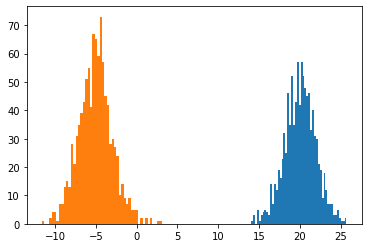

In [0]:
for hmm in two_reduced_hmms():
  plt.hist(hmm.sample(1000)[0], bins=50)
plt.show()

**This is the model we are trying to cluster**

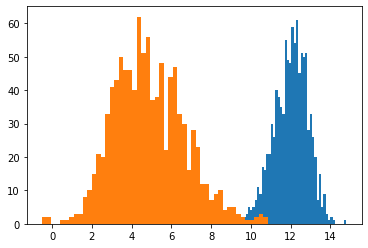

In [0]:
for hmm in two_different_hmms():
  plt.hist(hmm.sample(1000)[0], bins=50)
plt.show()

*Run VHEM with these inputs*

In [0]:
initial_h3m_two_base, initial_h3m_two_base_a = generate_synthetic(two_different_hmms(), T=10, sigma=4)
reduced_h3m_two_base, _ = generate_synthetic(two_reduced_hmms(), T=10, sigma=4, K=1)
two_base = VHEM(initial_h3m_two_base, reduced_h3m_two_base, N=10, tau=10, states=[0,1,2])
objective_list1, zs1, reduced1 = two_base.run_VHEM()

diff:  -1
OBJ -95.32743261469516
new diff 95.32743261469516
diff:  95.32743261469516
OBJ -85.73498833420628
new diff 9.592444280488877
diff:  9.592444280488877
OBJ -84.56234345038175
new diff 1.1726448838245318
diff:  1.1726448838245318
OBJ -84.50878026056125
new diff 0.05356318982049402
diff:  0.05356318982049402
OBJ -84.50221024275695
new diff 0.0065700178043073265


*Below is the probability that the ith HMM in the base model belongs in the jth HMM in the reduced model.*

In [0]:
zs1

[[1.0, 6.680920141381742e-42],
 [1.0, 3.7896556798572665e-45],
 [4.1947185134864535e-61, 1.0],
 [3.815572876517371e-60, 1.0]]

*Below is what our reduced model distributions a*

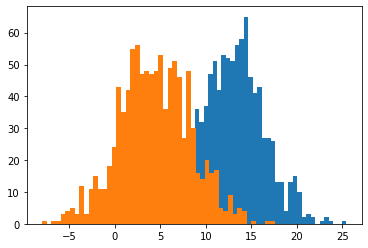

In [0]:
for hmm in reduced1.hmms:
  base = hmml.GMMHMM(n_components = 3)
  base.startprob_ = hmm.pi 
  base.transmat_ = hmm.transitions
  base.means_ = np.array([gmm.means for gmm in hmm.gmms]).reshape(-1, 1, 1)
  base.covars_ = np.array([gmm.sigma for gmm in hmm.gmms]).reshape(-1, 1, 1)
  base.weights_ = np.array([gmm.components for gmm in hmm.gmms])
  plt.hist(base.sample(1000)[0], bins=50)
plt.show()

Here we can also see correctness of the EM algorithm by observing a monotonically increasing value of $\mathcal{L}_{H3M}$, the variational lower bound, over iterations of the hierarchical EM algorithm. However, this clustering seems to be very messy when visualized: the distributions do not separate perfectly into the two initial distributions we started with, but rather spread out over both.

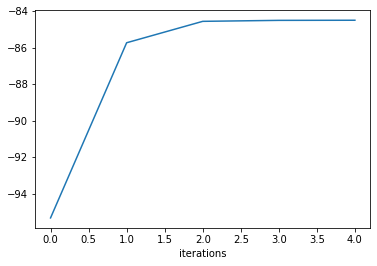

In [0]:
plt.plot(objective_list1)
plt.xlabel("iterations")
plt.show()

With two more similar HMMs, we see non-optimal clustering results, as intuitively expected: since the HMMs essentially fall in the same cluster initially, the resulting distributions of the clusters from VHEM also are indistinguishable, and the probabilities $z_{i, j}$ of the $i$th HMM of the base H3M corresponding to the $j$th HMM of the base H3M are not physically meaningful.

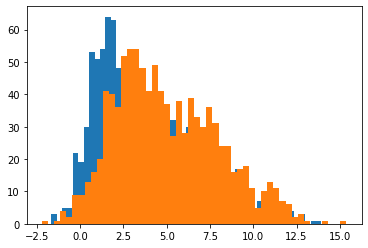

In [0]:
for hmm in two_similar_hmms():
  plt.hist(hmm.sample(1000)[0], bins=50)
plt.show()

In [0]:
initial_h3m_two_base_2, initial_h3m_two_base_2_a = generate_synthetic(two_similar_hmms(), T=10)
reduced_h3m_two_base_2, _ = generate_synthetic(two_reduced_hmms(), T=10, K=1)

two_base_2 = VHEM(initial_h3m_two_base_2, reduced_h3m_two_base_2, N=10, tau=10, states=[0,1,2])
objective_list2, zs2, reduced2 = two_base_2.run_VHEM()

diff:  -1
OBJ -84.84556150063727
new diff 84.84556150063727
diff:  84.84556150063727
OBJ -83.25807734957692
new diff 1.5874841510603517
diff:  1.5874841510603517
OBJ -75.30152470864286
new diff 7.9565526409340634
diff:  7.9565526409340634
OBJ -74.70410932162723
new diff 0.59741538701563
diff:  0.59741538701563
OBJ -74.70002920282974
new diff 0.004080118797489263


In [0]:
zs2

[[1.5982915111746175e-196, 1.0],
 [8.087153844010347e-195, 1.0],
 [3.6708695927797515e-207, 1.0],
 [3.700911600517584e-202, 1.0]]

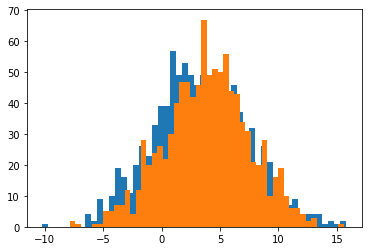

In [0]:
for hmm in reduced2.hmms:
  base = hmml.GMMHMM(n_components = 3)
  base.startprob_ = hmm.pi 
  base.transmat_ = hmm.transitions
  base.means_ = np.array([gmm.means for gmm in hmm.gmms]).reshape(-1, 1, 1)
  base.covars_ = np.array([gmm.sigma for gmm in hmm.gmms]).reshape(-1, 1, 1)
  base.weights_ = np.array([gmm.components for gmm in hmm.gmms])
  plt.hist(base.sample(1000)[0], bins=50)
plt.show()

Finally, we take a toy example from Coviello with non-trivial transition matrices. We start with four initial HMMs, construct two from each reduced HMM, and then try to get back the original four. The initial four HMMs have the same parameters for everything except the means of the three Gaussian components of the emission GMMs:

$$\pi = \begin{bmatrix}1/3 \\ 1/3 \\ 1/3\end{bmatrix}, A = \begin{bmatrix}0.8 & 0.1 & 0.1 \\ 0.2 & 0.8 & 0 \\ 0 & 0.2 & 0.8\end{bmatrix}, \sigma_\rho = 0.5\forall\rho$$

$$\mu_1 = \begin{bmatrix}1 \\ 2 \\ 3\end{bmatrix}, \mu_2 = \begin{bmatrix}3 \\ 2 \\ 1\end{bmatrix}, \mu_3 = \begin{bmatrix}1 \\ 2 \\ 2\end{bmatrix}, \mu_4 = \begin{bmatrix}1 \\ 3 \\ 3\end{bmatrix}$$

We see that the relative proximity in underlying distribution causes clustering to not perform terribly well in this example.

In [0]:
initial_h3m_four_base, initial_h3m_four_base_2 = generate_synthetic(coviello_hmms(), T=20)
reduced_h3m_four_base, _ = generate_synthetic(coviello_hmms(), T=20, K=1)

four_base = VHEM(initial_h3m_four_base, reduced_h3m_four_base, N=20, tau=10, states=[0,1,2])
objective_list3, zs3, reduced3 = four_base.run_VHEM()

diff:  -1
OBJ -63.96894244702689
new diff 63.96894244702689
diff:  63.96894244702689
OBJ -63.912057978408164
new diff 0.0568844686187262
diff:  0.0568844686187262
OBJ -63.914089626103085
new diff 0.00203164769492048


In [0]:
zs3 #All clustered to the same two HMM components of reduced H3M with similar distributions

[[3.1740425896155716e-09,
  1.676418025552179e-18,
  0.9899102844817367,
  0.010089712344220701],
 [1.0198229639917086e-10,
  5.460351423212925e-21,
  0.01684809787556233,
  0.9831519020224554],
 [1.418225524395441e-16,
  1.8381561111192197e-26,
  0.494451951094843,
  0.5055480489051568],
 [1.2515576723304436e-22,
  3.35515192377031e-36,
  7.556095240241646e-05,
  0.9999244390475976],
 [8.465900899781849e-13,
  1.1448912104364015e-22,
  0.4434981970142848,
  0.5565018029848686],
 [2.032466413670442e-18,
  1.5481322711389719e-27,
  0.2074608228352827,
  0.7925391771647172],
 [7.340491519267853e-14,
  4.479472105245196e-26,
  0.16159636965998705,
  0.8384036303399395],
 [1.0183136349214922e-20,
  3.3944808077356565e-31,
  9.293053919950418e-07,
  0.999999070694608]]

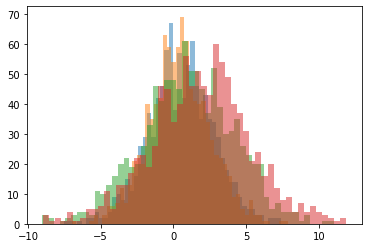

In [0]:
for hmm in reduced3.hmms:
  base = hmml.GMMHMM(n_components = 3)
  base.startprob_ = hmm.pi 
  base.transmat_ = hmm.transitions
  base.means_ = np.array([gmm.means for gmm in hmm.gmms]).reshape(-1, 1, 1)
  base.covars_ = np.array([gmm.sigma for gmm in hmm.gmms]).reshape(-1, 1, 1)
  base.weights_ = np.array([gmm.components for gmm in hmm.gmms])
  plt.hist(base.sample(1000)[0], bins=50, alpha=0.5)
plt.show()

In [0]:
import sklearn

lst, _ = generate_synthetic(two_different_hmms())
feats = []
for model in lst.hmms:
    feats.append(list(np.concatenate([model.pi, model.transitions.reshape(-1), np.concatenate([m.means for m in model.gmms]), np.concatenate([m.sigma for m in model.gmms]), np.concatenate([m.components for m in model.gmms])])))
clusterer = sklearn.cluster.KMeans(n_clusters = 2)
clusterer.fit(feats)
clusterer.cluster_centers_

array([[5.03383066e-01, 8.87145023e-10, 4.96616933e-01, 5.71050403e-01,
        1.30791104e-01, 2.98158493e-01, 1.58195227e-01, 7.40215222e-01,
        1.01589551e-01, 3.13451972e-01, 1.23470569e-01, 5.63077459e-01,
        3.87030570e+00, 8.00330683e+00, 3.60510077e+00, 6.38850611e+00,
        7.52357223e+00, 5.72025198e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00],
       [4.98834537e-01, 8.93005698e-04, 5.00272458e-01, 4.41046255e-01,
        3.26726891e-01, 2.32226853e-01, 3.30273851e-01, 3.82980607e-01,
        2.86745542e-01, 3.59304758e-01, 1.95113403e-01, 4.45581840e-01,
        1.22565463e+01, 1.25271753e+01, 1.24281796e+01, 5.16700095e+00,
        5.39992045e+00, 4.78445521e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00]])

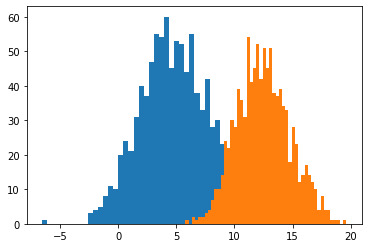

In [0]:
for data in clusterer.cluster_centers_:
  base = hmml.GMMHMM(n_components = 3)
  base.startprob_ = data[:3]
  base.transmat_ = data[3:12].reshape(3, 3)
  base.means_ = data[12:15].reshape(-1, 1, 1)
  base.covars_ = data[15:18].reshape(-1, 1, 1)
  base.weights_ = data[18:].reshape(3, 1)
  plt.hist(base.sample(1000)[0], bins=50)
plt.show()

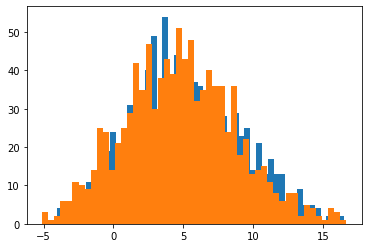

In [0]:
lst, _ = generate_synthetic(two_similar_hmms())
feats = []
for model in lst.hmms:
    feats.append(list(np.concatenate([model.pi, model.transitions.reshape(-1), np.concatenate([m.means for m in model.gmms]), np.concatenate([m.sigma for m in model.gmms]), np.concatenate([m.components for m in model.gmms])])))
clusterer2 = sklearn.cluster.KMeans(n_clusters = 2)
clusterer2.fit(feats)
for data in clusterer2.cluster_centers_:
  base = hmml.GMMHMM(n_components = 3)
  base.startprob_ = data[:3]
  base.transmat_ = data[3:12].reshape(3, 3)
  base.means_ = data[12:15].reshape(-1, 1, 1)
  base.covars_ = data[15:18].reshape(-1, 1, 1)
  base.weights_ = data[18:].reshape(3, 1)
  plt.hist(base.sample(1000)[0], bins=50)
plt.show()

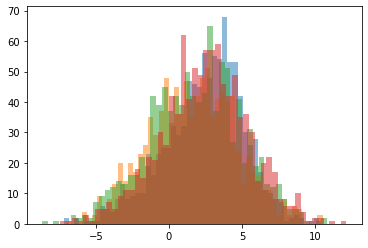

In [0]:
lst, _ = generate_synthetic(coviello_hmms())
feats = []
for model in lst.hmms:
    feats.append(list(np.concatenate([model.pi, model.transitions.reshape(-1), np.concatenate([m.means for m in model.gmms]), np.concatenate([m.sigma for m in model.gmms]), np.concatenate([m.components for m in model.gmms])])))
clusterer3 = sklearn.cluster.KMeans(n_clusters = 4)
clusterer3.fit(feats)
clusterer3.cluster_centers_

for data in clusterer3.cluster_centers_:
  base = hmml.GMMHMM(n_components = 3)
  base.startprob_ = data[:3]
  base.transmat_ = data[3:12].reshape(3, 3)
  base.means_ = data[12:15].reshape(-1, 1, 1)
  base.covars_ = data[15:18].reshape(-1, 1, 1)
  base.weights_ = data[18:].reshape(3, 1)
  plt.hist(base.sample(1000)[0], bins=50, alpha=0.5)
plt.show()

For these simple toy examples, we see remarkably similar performance between naive K-means clustering and our more involved algorithm (we do improve a bit in the edge case where we start with two similar HMMs, where our clusters end up having slightly tighter distributions). It is likely that the supposed inability to cluster based on parameters only comes into play in situations where the parameter space is of high dimensionality. Thus, the paper's claim is likely true only for more complex data which (1) exploit the flexibility of the hierarchical model well (i.e., use more Gaussian components) and (2)feature a prohibitively large HMM parameter space; in these cases, this algorithm may be practical and useful (in addition, it should be noted that this algorithm takes relatively short time; the paper reports optimized times of around 30 seconds for relatively large runs on complex motion-capture data, and we also found for our own examples that nearly all runs took less than 10 seconds). For instance, the paper ran experiments on clustering motion-capture data, classifying genre/instrumentation of music files, and classifying hand-writing using research-standard datasets like MOCAP, showing the algorithm's performance to better or at worst comparable to many similarly state-of-the-art HMM clustering algorithms,most notably the spectral clustering algorithm PPK-SC (the Jebara et al., 2007 paper referenced earlier). An exception is an "EM-H3M" algorithm that outperforms VHEM in classification accuracy on music tagging, but this algorithm runs a full 6 times faster, so there exists a tradeoff between time and accuracy in this case.


While reading the paper led us to conclude that the experimental evidence was strong, with sufficient evidence of improved performance on datasets of varied complexity (including the above toy example), from our data it may be possible that some of the paper's conclusions are due to overfitting, just extrapolating from the algorithm's inability to outperform sklearn on simple tests. More involved checks on their experiments on slightly larger tests and motion-capture data would be necessary to fully determine the practicality of the VHEM algorithm. Future steps to be taken here may include learning the number of optimal components of the reduced H3M (i.e., seeing what the optimal number of clusters is through observing final $\mathcal{L}_{H3M}$ values in each case), or learning the optimum number of Gaussian mixture model components in the reduced model (by mixing several different types of GMM-HMMs in the same H3M).